load libraries

In [1]:
import os
import cv2
import glob
import numpy as np
import pandas as pd

from keras.models import *
from keras.optimizers import *
from keras.layers import *
from keras.applications import *
from keras.preprocessing.image import *

Using TensorFlow backend.


In [2]:
dir = "/ext/Data/distracted_driver_detection/"

model_image_size = (299, 299)
fine_tune_layer = 172

def lambda_func(x):
    x /= 255.
    x -= 0.5
    x *= 2
    return x

# 加载数据集

load train data

In [3]:
train_gen = ImageDataGenerator(
    featurewise_std_normalization=True,
    samplewise_std_normalization=False,
    rotation_range=10.,
    width_shift_range=0.05,
    height_shift_range=0.05,
    shear_range=0.1,
    zoom_range=0.1,
)
gen = ImageDataGenerator(
    featurewise_std_normalization=True,
    samplewise_std_normalization=False,
)

batch_size = 128
train_generator = train_gen.flow_from_directory(os.path.join(dir, 'train'),  model_image_size, shuffle=True, batch_size=batch_size, class_mode="categorical")
print("subdior to train type {}".format(train_generator.class_indices))
valid_generator = gen.flow_from_directory(os.path.join(dir, 'valid'),  model_image_size, shuffle=True, batch_size=batch_size, class_mode="categorical")
print("subdior to valid type {}".format(valid_generator.class_indices))

Found 22424 images belonging to 10 classes.
subdior to train type {'c0': 0, 'c1': 1, 'c2': 2, 'c3': 3, 'c4': 4, 'c5': 5, 'c6': 6, 'c7': 7, 'c8': 8, 'c9': 9}
Found 641 images belonging to 10 classes.
subdior to valid type {'c0': 0, 'c1': 1, 'c2': 2, 'c3': 3, 'c4': 4, 'c5': 5, 'c6': 6, 'c7': 7, 'c8': 8, 'c9': 9}


# 构建模型

https://github.com/fchollet/keras/blob/master/keras/applications/inceptionV3.py


In [4]:
input_tensor = Input((*model_image_size, 3))
x = input_tensor
if lambda_func:
    x = Lambda(inception_v3.preprocess_input)(x)

base_model = InceptionV3(input_tensor=Input((*model_image_size, 3)), weights='imagenet', include_top=False)

x = GlobalAveragePooling2D()(base_model.output)
x = Dropout(0.5)(x)
x = Dense(10, activation='softmax')(x)
model = Model(base_model.input, x)

print("total layer count {}".format(len(base_model.layers)))

for i in range(fine_tune_layer):
    model.layers[i].trainable = False



total layer count 311


# 训练模型

In [5]:
print("train_generator.samples = {}".format(train_generator.samples))
print("valid_generator.samples = {}".format(valid_generator.samples))
steps_train_sample = train_generator.samples // 128 + 1
steps_valid_sample = valid_generator.samples // 128 + 1

train_generator.samples = 22424
valid_generator.samples = 641


In [6]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.fit_generator(train_generator, steps_per_epoch=steps_train_sample, epochs=6, validation_data=valid_generator, validation_steps=steps_valid_sample)

model.save("models/inceptionV3-imagenet-finetune{}-adam.h5".format(fine_tune_layer))
print("model saved!")

Epoch 1/6


/home/jidou/anaconda3/lib/python3.6/site-packages/keras/preprocessing/image.py:514: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn'tbeen fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


176/176 [==============================] - 255s - loss: 0.1811 - acc: 0.9422 - val_loss: 0.4369 - val_acc: 0.9158

In [7]:
model.compile(optimizer=RMSprop(lr=1*0.00001), loss='categorical_crossentropy', metrics=['accuracy'])
model.fit_generator(train_generator, steps_per_epoch=steps_train_sample, epochs=10, validation_data=valid_generator, validation_steps=steps_valid_sample)

model.save("models/inceptionV3-imagenet-finetune{}.h5".format(fine_tune_layer))
print("model saved!")

Epoch 1/10


/home/jidou/anaconda3/lib/python3.6/site-packages/keras/preprocessing/image.py:514: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn'tbeen fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


176/176 [==============================] - 254s - loss: 0.0090 - acc: 0.9969 - val_loss: 0.4200 - val_acc: 0.9080

# 可视化模型

https://keras.io/visualization/

In [14]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.models import *

model = load_model("models/inceptionV3-imagenet-finetune{}.h5".format(fine_tune_layer))
print("load successed")

#SVG(model_to_dot(model).create(prog='dot', format='svg'))

load successed


# CAM 可视化

http://cnnlocalization.csail.mit.edu/

![](http://cnnlocalization.csail.mit.edu/framework.jpg)

$cam = (P-0.5)*w*output$

* cam: 类激活图 7\*7
* P: 猫狗概率
* output: 卷积层的输出 2048\*1
* w: 卷积核的权重 7\*7\*2048

In [9]:
z = zip([x.name for x in model.layers], range(len(model.layers)))
for k, v in z:
    print("{} - {}".format(k,v))

input_2 - 0
conv2d_1 - 1
batch_normalization_1 - 2
activation_1 - 3
conv2d_2 - 4
batch_normalization_2 - 5
activation_2 - 6
conv2d_3 - 7
batch_normalization_3 - 8
activation_3 - 9
max_pooling2d_1 - 10
conv2d_4 - 11
batch_normalization_4 - 12
activation_4 - 13
conv2d_5 - 14
batch_normalization_5 - 15
activation_5 - 16
max_pooling2d_2 - 17
conv2d_9 - 18
batch_normalization_9 - 19
activation_9 - 20
conv2d_7 - 21
conv2d_10 - 22
batch_normalization_7 - 23
batch_normalization_10 - 24
activation_7 - 25
activation_10 - 26
average_pooling2d_1 - 27
conv2d_6 - 28
conv2d_8 - 29
conv2d_11 - 30
conv2d_12 - 31
batch_normalization_6 - 32
batch_normalization_8 - 33
batch_normalization_11 - 34
batch_normalization_12 - 35
activation_6 - 36
activation_8 - 37
activation_11 - 38
activation_12 - 39
mixed0 - 40
conv2d_16 - 41
batch_normalization_16 - 42
activation_16 - 43
conv2d_14 - 44
conv2d_17 - 45
batch_normalization_14 - 46
batch_normalization_17 - 47
activation_14 - 48
activation_17 - 49
average_pooling

http://docs.opencv.org/trunk/d3/d50/group__imgproc__colormap.html

![](http://docs.opencv.org/trunk/colorscale_jet.jpg)

In [10]:
import matplotlib.pyplot as plt
import random
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

def show_heatmap_image(model_show, weights_show):
    test_dir = os.path.join(dir,  "test", "test" )
    image_files = glob.glob(os.path.join(test_dir,"*"))
    print(len(image_files))
    
    plt.figure(figsize=(12, 24))
    for i in range(10):
        plt.subplot(5, 2, i+1)
        img = cv2.imread(image_files[2000*i+113])
        img = cv2.resize(img,  (model_image_size[1],model_image_size[0]))
        x = img.copy()
        x.astype(np.float32)
        out, predictions = model_show.predict(np.expand_dims(x, axis=0))
        predictions = predictions[0]
        out = out[0]
        
        max_idx = np.argmax(predictions)
        prediction = predictions[max_idx]

        status = ["safe driving",  " texting - right",  "phone - right",  "texting - left",  "phone - left",  
                  "operation radio", "drinking", "reaching behind", "hair and makeup", "talking"]

        plt.title('c%d |%s| %.2f%%' % (max_idx , status[max_idx], prediction*100))
    
        cam = (prediction - 0.5) * np.matmul(out, weights_show)
        cam = cam[:,:,max_idx]
        cam -= cam.min()
        cam /= cam.max()
        cam -= 0.2
        cam /= 0.8

        cam = cv2.resize(cam, (model_image_size[1],model_image_size[0]))
        heatmap = cv2.applyColorMap(np.uint8(255*cam), cv2.COLORMAP_JET)
        heatmap[np.where(cam <= 0.2)] = 0

        out = cv2.addWeighted(img, 0.8, heatmap, 0.4, 0)

        plt.axis('off')
        plt.imshow(out[:,:,::-1])
print("done")

done


layer_output Tensor("mixed10_1/concat:0", shape=(?, 8, 8, 2048), dtype=float32)
weights shape (2048, 10)
79726


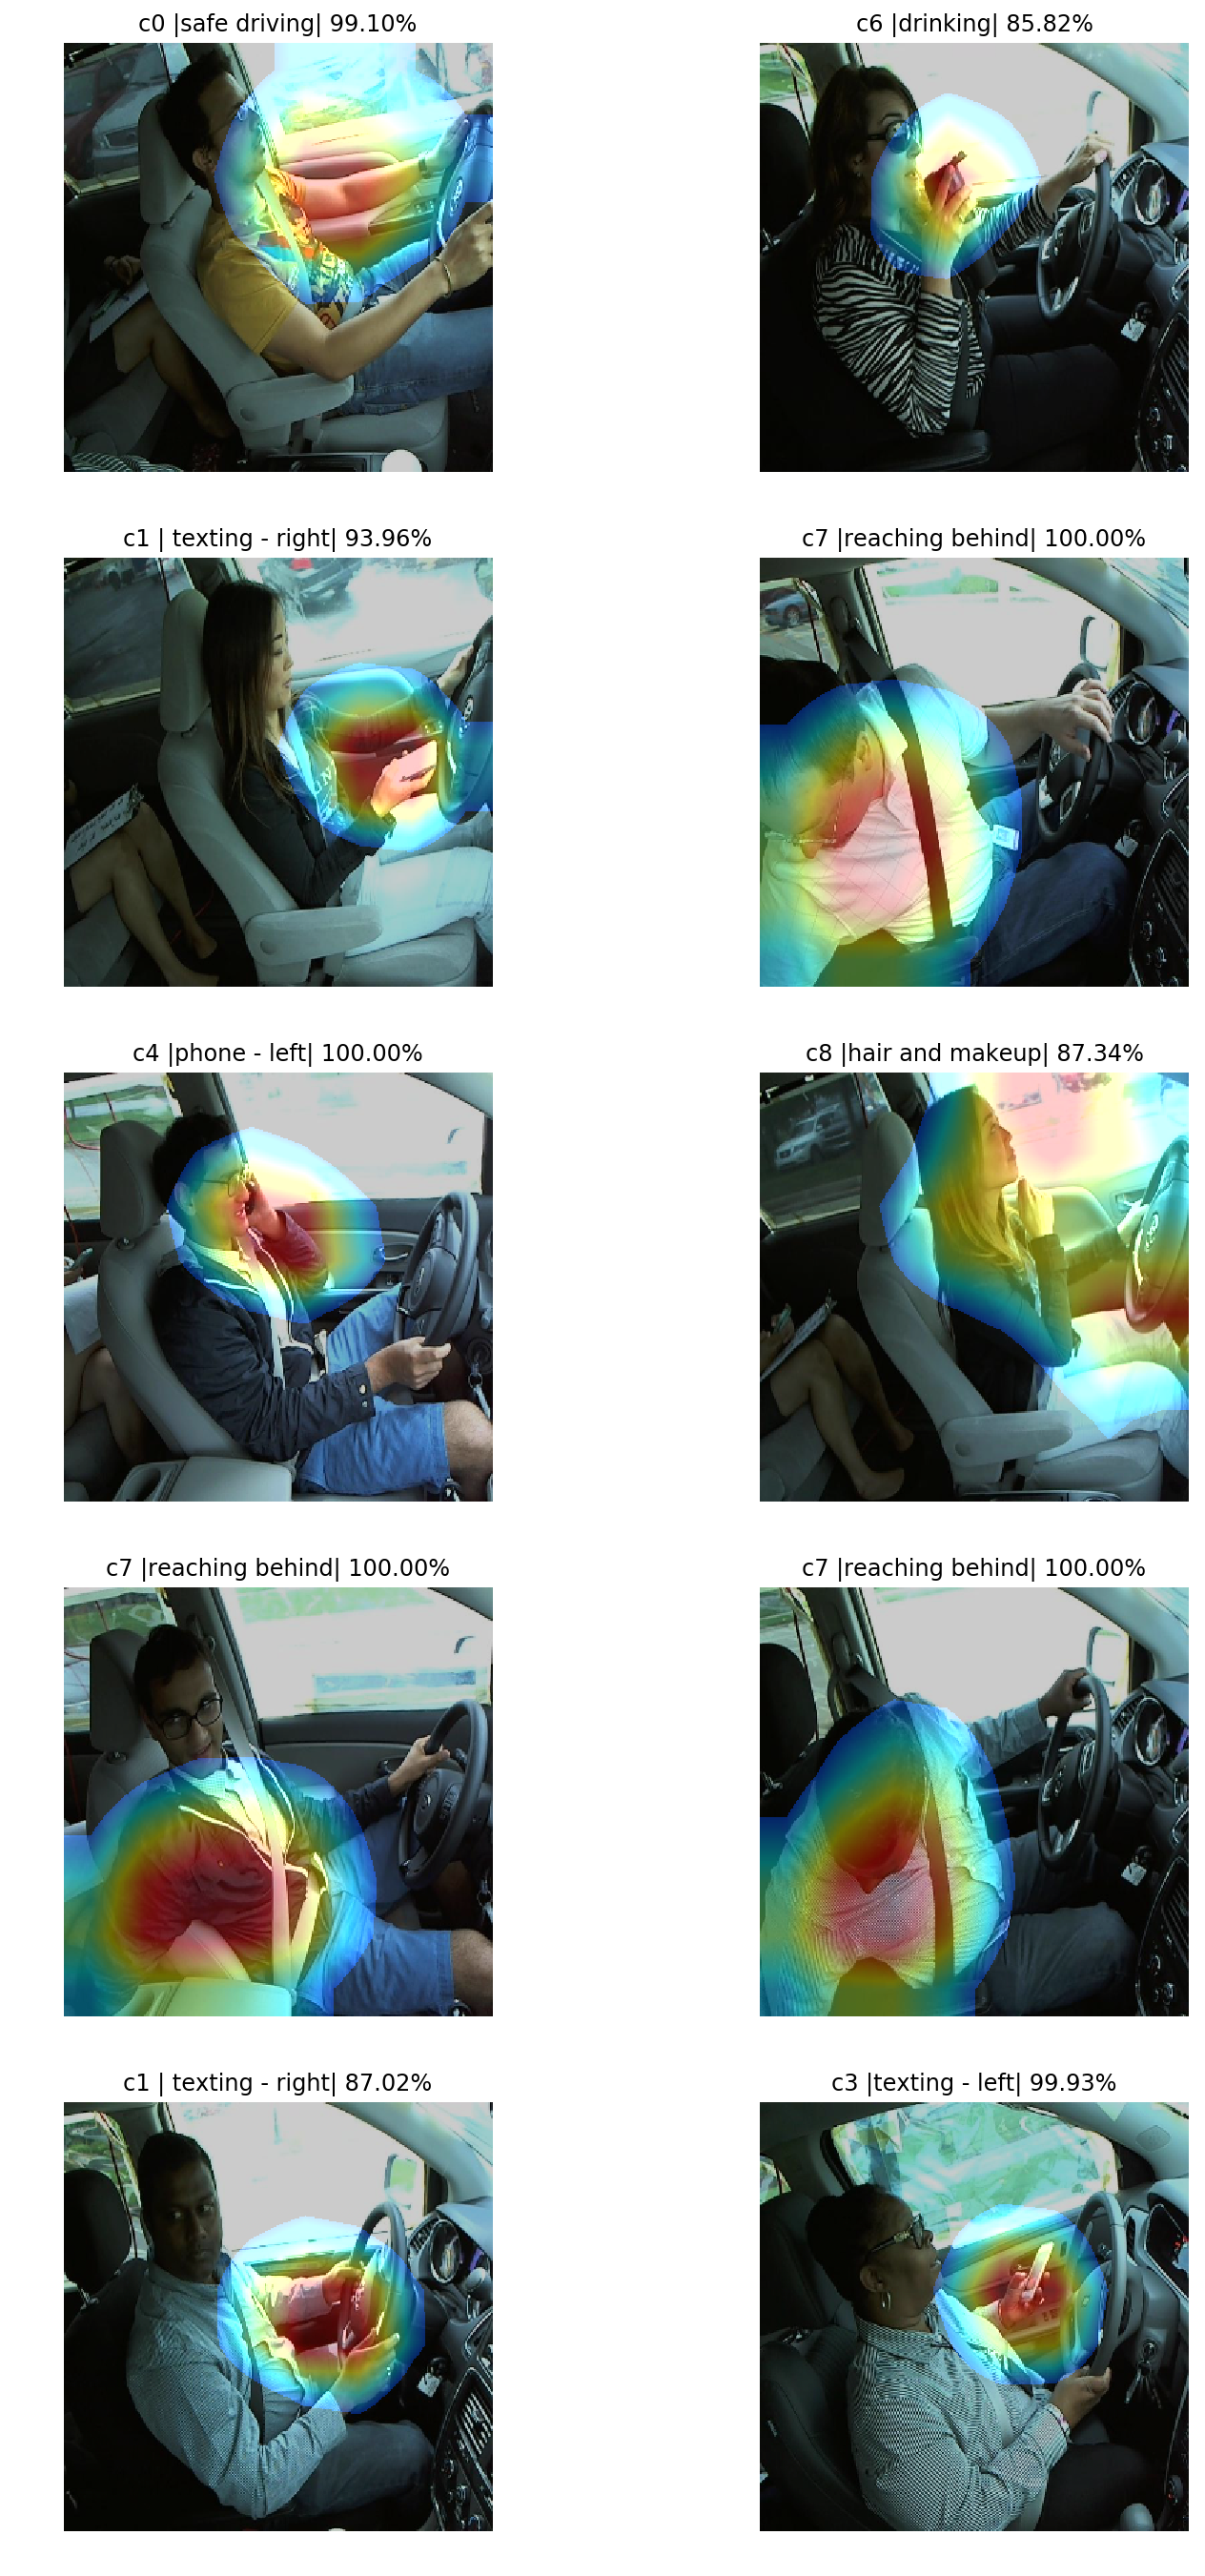

In [11]:
weights = model.layers[313].get_weights()[0]
layer_output = model.layers[310].output
model2 = Model(model.input, [layer_output, model.output])
print("layer_output {0}".format(layer_output))
print("weights shape {0}".format(weights.shape))
show_heatmap_image(model2, weights)

In [15]:
def gen_kaggle_csv(model,  model_image_size, csv_name):
    dir = "/ext/Data/distracted_driver_detection/"

    gen = ImageDataGenerator()
    test_generator = gen.flow_from_directory(dir + "test/",  model_image_size, shuffle=False, 
                                             batch_size=128, class_mode=None)
#     s = test_generator.__dict__
#     del s['filenames']
#     print(s)
    y_pred = model.predict_generator(test_generator,  steps=test_generator.samples//128+1,  verbose=1)
    print("y_pred shape {}".format(y_pred.shape))
    y_pred = y_pred.clip(min=0.005, max=0.995)
    print(y_pred[:3])

    l = list()
    for i, fname in enumerate(test_generator.filenames):
        name = fname[fname.rfind('/')+1:]
        l.append( [name, *y_pred[i]] )

    l = np.array(l)
    data = {'img': l[:,0]}
    for i in range(10):
        data["c%d"%i] = l[:,i+1]
    df = pd.DataFrame(data, columns=['img'] + ['c%d'%i for i in range(10)])
    df.head(10)
    df = df.sort_values(by='img')
    df.to_csv(csv_name, index=None, float_format='%.3f')
    print("csv saved")

print("done")

done


In [16]:
gen_kaggle_csv(model,  model_image_size, 'csv/InceptionV3-imagenet-finetune{}-pred.csv'.format(fine_tune_layer))

Found 79726 images belonging to 1 classes.
623/623 [==============================] - 393s      